# Installation

In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 35.5 MB/s 
     |████████████████████████████████| 432 kB 62.8 MB/s 
     |████████████████████████████████| 6.6 MB 61.4 MB/s 
     |████████████████████████████████| 163 kB 68.8 MB/s 
     |████████████████████████████████| 115 kB 71.0 MB/s 
     |████████████████████████████████| 212 kB 74.9 MB/s 
     |████████████████████████████████| 127 kB 74.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Imports

In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Dense,Flatten,InputLayer,BatchNormalization,Dropout,Input,LayerNormalization
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import (BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives,
                                       TrueNegatives, Precision, Recall, AUC, binary_accuracy,Accuracy,
                                       TopKCategoricalAccuracy, CategoricalAccuracy,SparseCategoricalAccuracy)
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from datasets import load_dataset
from transformers import (BertTokenizerFast,TFBertTokenizer,BertTokenizer,RobertaTokenizerFast,
                          DataCollatorWithPadding,TFRobertaForSequenceClassification,TFBertForSequenceClassification,
                          TFBertModel,create_optimizer,TFDebertaForSequenceClassification,DebertaTokenizerFast)

In [ ]:
BATCH_SIZE=16

# Data Preparation

In [ ]:
!pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d bitext/training-dataset-for-chatbotsvirtual-assistants
!unzip "/content/training-dataset-for-chatbotsvirtual-assistants.zip" -d "/content/dataset/"

  0% 0.00/1.16M [00:00<?, ?B/s]
100% 1.16M/1.16M [00:00<00:00, 174MB/s]
Archive:  /content/training-dataset-for-chatbotsvirtual-assistants.zip
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv  
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.xlsx  
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/LICENSE.txt  
  inflating: /content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample

In [ ]:
dataset=load_dataset("csv",
                       data_files="/content/dataset/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample/20000-Utterances-Training-dataset-for-chatbots-virtual-assistant-Bitext-sample.csv")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-14cfeb140f0630e0/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['flags', 'utterance', 'category', 'intent'],
        num_rows: 21534
    })
})

In [ ]:
dataset['train'][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 'create_account'}

In [ ]:
intents=list(set(dataset['train']['intent']))
dict_intents={intents[i]: i for i in range(len(intents))}
print(dict_intents)
print(len(intents))

{'recover_password': 0, 'cancel_order': 1, 'payment_issue': 2, 'delivery_options': 3, 'switch_account': 4, 'delete_account': 5, 'edit_account': 6, 'review': 7, 'set_up_shipping_address': 8, 'check_cancellation_fee': 9, 'place_order': 10, 'newsletter_subscription': 11, 'get_invoice': 12, 'change_order': 13, 'check_refund_policy': 14, 'contact_human_agent': 15, 'change_shipping_address': 16, 'get_refund': 17, 'track_refund': 18, 'delivery_period': 19, 'check_invoices': 20, 'create_account': 21, 'check_payment_methods': 22, 'complaint': 23, 'track_order': 24, 'registration_problems': 25, 'contact_customer_service': 26}
27


In [ ]:
def preprocess(dataset):
  return {'utterance':dataset['utterance'],
          'intent':dict_intents[dataset['intent']]}

In [ ]:
prep_dataset=dataset.map(preprocess)

  0%|          | 0/21534 [00:00<?, ?ex/s]

In [ ]:
prep_dataset['train'][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 21}

In [ ]:
model_id="microsoft/deberta-base"
tokenizer = DebertaTokenizerFast.from_pretrained(model_id)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/474 [00:00<?, ?B/s]

In [ ]:
def tokenizer_function(dataset):
  return tokenizer(dataset["utterance"],)

In [ ]:
tokenized_dataset=prep_dataset.map(tokenizer_function)

  0%|          | 0/21534 [00:00<?, ?ex/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['flags', 'utterance', 'category', 'intent', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 21534
    })
})

In [ ]:
tokenized_dataset['train'][0]

{'flags': 'BILC',
 'utterance': "I don't have an online account, what do I have to do to register?",
 'category': 'ACCOUNT',
 'intent': 21,
 'input_ids': [1,
  100,
  218,
  75,
  33,
  41,
  804,
  1316,
  6,
  99,
  109,
  38,
  33,
  7,
  109,
  7,
  5124,
  116,
  2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [ ]:
tf_dataset = tokenized_dataset["train"].to_tf_dataset(
    columns=['input_ids','attention_mask', 'intent'],
    shuffle=True, 
    batch_size=BATCH_SIZE,
    collate_fn=data_collator
)

You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [ ]:
def swap_positions(dataset):
  return {'input_ids':dataset['input_ids'],
          'attention_mask':dataset['attention_mask'],},dataset['intent']

In [ ]:
tf_dataset=tf_dataset.map(swap_positions)

In [ ]:
train_dataset=tf_dataset.take(int(0.9*len(tf_dataset)))
val_dataset=tf_dataset.skip(int(0.9*len(tf_dataset)))

In [ ]:
for i in val_dataset.take(1):
  print(i)

({'input_ids': <tf.Tensor: shape=(16, 24), dtype=int64, numpy=
array([[    1,  9178,   109,    38, 10061,   127,  3018,  1316,   116,
            2,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    1,  8569,   109,    38,  1649,     5,  1735,    13,  2996,
          116,     2,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    1, 19178,   162,   120,   103,  4033,     2,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [    1,  4783,   804,  1316,    18,    57, 16341,     6,    99,
          197,    38,   109,     7,  5312,    24,   116,     2,     0,
            0,     0,     0,     0,     0,     0],
       [    1,  4970,    41,  2936,   114,   939,    64,  1994,    19,
         2111,   544,     2,     0,     0,     0,     0,     0,     0,
            0,     0,  

# Modeling

## Based on TFDebertaForSequenceClassification

In [ ]:
model=TFDebertaForSequenceClassification.from_pretrained(model_id,num_labels=len(intents))
model.summary()

Downloading:   0%|          | 0.00/555M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaForSequenceClassification.

Some layers of TFDebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['cls_dropout', 'pooler', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_deberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 deberta (TFDebertaMainLayer  multiple                 138601728 
 )                                                               
                                                                 
 pooler (TFDebertaContextPoo  multiple                 590592    
 ler)                                                            
                                                                 
 cls_dropout (TFDebertaStabl  multiple                 0         
 eDropout)                                                       
                                                                 
 classifier (Dense)          multiple                  20763     
                                                                 
Total params: 139,213,083
Trainable params: 139,213,083
Non-trainable params: 0
______________

# Training

In [ ]:
num_epochs = 2
batches_per_epoch = len(tokenized_dataset["train"]) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

In [ ]:
optimizer, schedule = create_optimizer(init_lr=2e-5,num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
model.compile(optimizer=optimizer,
    metrics=["accuracy"])

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


In [ ]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=2,)

Epoch 1/2
1211/1211 [==============================] - 249s 205ms/step - loss: 0.0036 - accuracy: 0.9998 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 2/2
  28/1211 [..............................] - ETA: 3:57 - loss: 0.0029 - accuracy: 1.0000

KeyboardInterrupt: ignored

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Evaluation

## Confusion Matrix

In [ ]:
predicted = []
labels = []

for input, label in val_dataset:
  predicted.append(model(**input).logits)
  labels.append(label.numpy())

In [ ]:
print(predicted)
print(labels)

[<tf.Tensor: shape=(16, 27), dtype=float32, numpy=
array([[-3.19677144e-02, -9.44107652e-01,  4.55888594e-03,
        -1.40890229e+00, -1.19679749e+00,  2.68556148e-01,
        -1.25625229e+00,  2.15255037e-01, -1.56347096e+00,
        -8.80063951e-01, -1.34098053e+00, -1.07151508e+00,
         7.58284211e-01,  5.23810625e-01,  3.96231920e-01,
        -1.06731451e+00,  1.60944477e-01, -1.17910826e+00,
        -9.77437437e-01, -1.36442411e+00,  9.73077297e+00,
        -5.67585051e-01, -7.12999761e-01, -7.50252008e-01,
         1.09767044e+00, -7.32102454e-01,  2.16616645e-01],
       [-1.18517613e+00, -1.27534306e+00,  1.86288938e-01,
        -6.69533134e-01,  2.15688288e-01,  1.33206680e-01,
        -2.01073742e+00, -1.53208470e+00, -2.36307904e-01,
        -1.41729903e+00,  6.81551546e-02, -1.57004488e+00,
        -8.19745064e-01, -1.34022284e+00, -5.17338812e-01,
        -7.20082104e-01, -1.65931487e+00, -1.86643228e-01,
        -1.85401607e+00, -4.35232133e-01, -1.12074065e+00,
    

In [ ]:
print(tf.argmax(predicted[:-1],axis=-1).numpy())
print(labels[:-1])

[[20 21  4 ... 26  4 25]
 [12 12  2 ...  2 21 26]
 [24  4 26 ...  2  2 21]
 ...
 [12 18  0 ... 21 12  5]
 [23 17 19 ... 17 21 26]
 [10  9  2 ...  9 24  2]]
[array([20, 21,  4,  2, 17, 14,  3,  7, 17, 24,  2, 23, 13, 26,  4, 25]), array([12, 12,  2, 15, 26, 20, 26, 15, 17, 24, 21,  7, 24,  2, 21, 26]), array([24,  4, 26,  2,  7, 17, 17,  2, 20, 13,  0, 21,  2,  2,  2, 21]), array([14,  5,  2, 22, 15, 17,  3,  0, 26, 15, 21, 20, 26, 10, 20, 26]), array([ 5, 26, 23, 12, 26,  2, 12,  5, 22, 26, 26,  0, 21,  2, 13, 13]), array([26, 26,  2, 15, 13, 26,  2,  2, 12, 21, 23, 22, 12, 16, 26,  3]), array([ 2,  2, 15, 21, 11, 17, 15,  7, 24, 17, 20, 24, 15,  2, 20,  4]), array([21,  6, 13,  6,  4, 21, 17, 21,  2,  7, 12, 21, 13,  7, 11,  0]), array([24,  7,  2,  2, 13, 26, 12,  0,  2, 21, 25,  2, 13, 26, 20, 21]), array([ 2, 14, 24,  2, 21,  6, 12, 21, 12,  5, 21, 21,  2, 17, 24,  2]), array([15,  2, 17,  5, 15, 20, 26, 13,  5,  2, 21,  2, 26, 12, 12, 24]), array([24,  2,  2, 19,  2,  2, 13,  1,  

In [ ]:
print(np.concatenate([np.array(labels[:-1]).flatten(),np.array(labels[-1]).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[20 21  4 ... 13 15 20]
[20 21  4 ... 13 15 20]


In [ ]:
pred=np.concatenate([np.array(labels[:-1]).flatten(),np.array(labels[-1]).flatten()])
lab=np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])

[[ 89   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0 414   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0  39   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0  26   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  80   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  11   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  61   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   9   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 

Text(0.5, 123.0, 'Predicted')

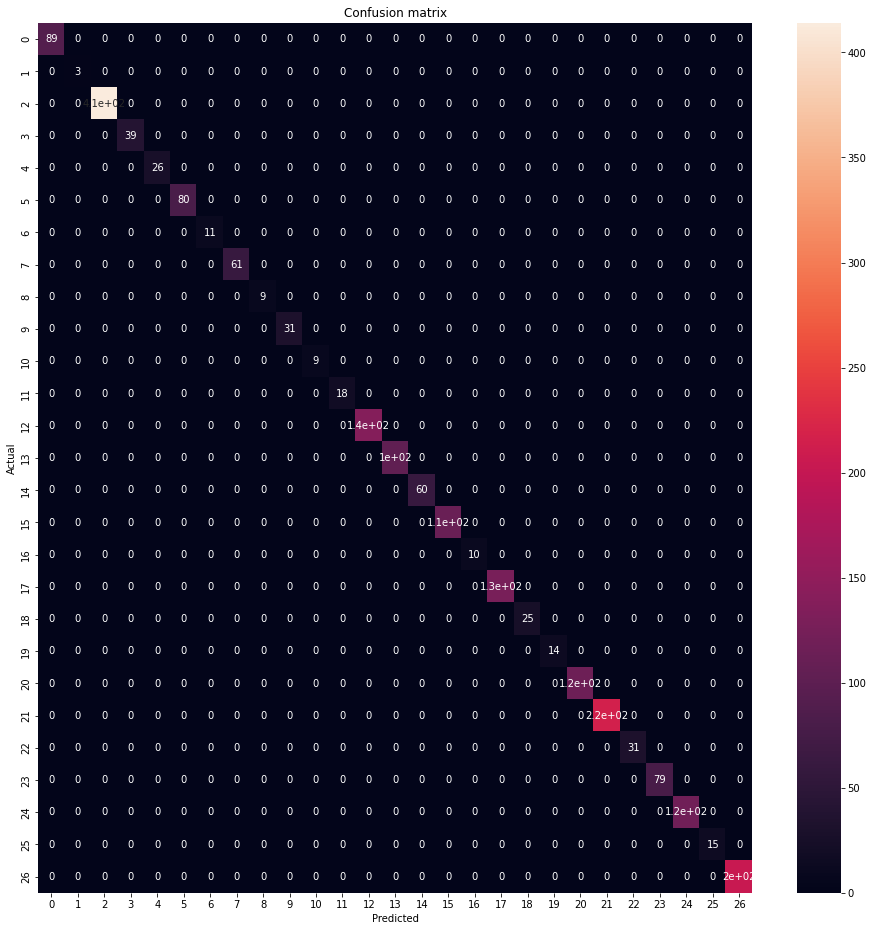

In [ ]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(16,16))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Testing


In [ ]:
inputs = tokenizer(["Please how do i go about the account creation? ",
                    "After setting up my account, i feel like i need to change it. How do i go about that?",
                    "how do i know how much i need to pay?",
                    "purchased a product, which i now want to change"
                    ], padding=True,return_tensors="tf")

logits = model(**inputs).logits
outputs=tf.argmax(logits,axis=-1).numpy()

In [ ]:
print(outputs)

[11  6 25 21]


In [ ]:
reverse_dict_intents={i:intents[i] for i in range(len(intents))}
print(reverse_dict_intents)

{0: 'registration_problems', 1: 'get_refund', 2: 'set_up_shipping_address', 3: 'check_refund_policy', 4: 'contact_human_agent', 5: 'complaint', 6: 'switch_account', 7: 'check_invoices', 8: 'cancel_order', 9: 'review', 10: 'check_cancellation_fee', 11: 'create_account', 12: 'payment_issue', 13: 'track_order', 14: 'track_refund', 15: 'place_order', 16: 'delete_account', 17: 'delivery_options', 18: 'edit_account', 19: 'delivery_period', 20: 'get_invoice', 21: 'change_order', 22: 'change_shipping_address', 23: 'recover_password', 24: 'contact_customer_service', 25: 'check_payment_methods', 26: 'newsletter_subscription'}


In [ ]:
for i in outputs:
  print(reverse_dict_intents[i])

create_account
switch_account
check_payment_methods
change_order
